# Customer Segmentation Based on Credit Card Data

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ccdata/CC GENERAL.csv


In [15]:
import warnings
warnings.filterwarnings('ignore')

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.cluster import vq
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import tqdm

In [18]:
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from scipy.cluster.hierarchy import dendrogram, cophenet, linkage
from scipy.spatial.distance import pdist, cdist

In [19]:
data = pd.read_csv("/kaggle/input/ccdata/CC GENERAL.csv")
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [21]:
data.drop('CUST_ID', axis=1, inplace=True)

In [22]:
data.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**Filling the missing value of credit limit with mean**

In [23]:
data.CREDIT_LIMIT = data.CREDIT_LIMIT.fillna(data.CREDIT_LIMIT.mean())

In [24]:
def univariate_n(x):
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    sns.distplot(x, ax=ax[0,0])
    ax[0,0].set_title(f"Histogram of {x.name}")
    
    sns.boxplot(x, ax=ax[0,1])
    ax[0,1].set_title(f"Boxplot of {x.name}")
    
    sns.kdeplot(x, cumulative=True, ax=ax[1,0])
    ax[1,0].set_title(f"CDF of {x.name}")
    
    st.probplot(x, plot=ax[1,1])
    

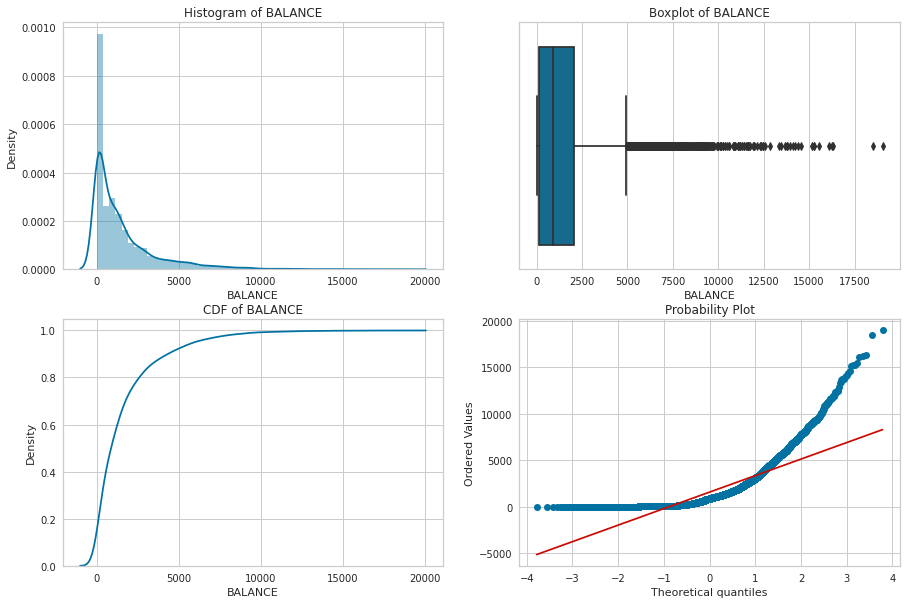

In [25]:
univariate_n(data.BALANCE)

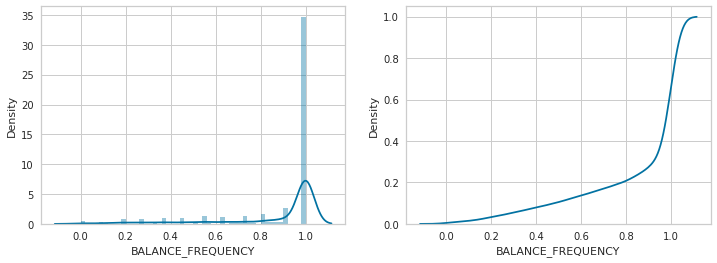

In [26]:
f, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.distplot(data.BALANCE_FREQUENCY, ax=ax1)
sns.kdeplot(data.BALANCE_FREQUENCY, cumulative=True, ax=ax2);

In [27]:
pd.value_counts(data.BALANCE_FREQUENCY)

1.000000    6211
0.909091     410
0.818182     278
0.727273     223
0.545455     219
0.636364     209
0.454545     172
0.363636     170
0.272727     151
0.181818     146
0.000000      80
0.090909      67
0.833333      60
0.875000      57
0.900000      55
0.888889      53
0.857143      51
0.500000      40
0.666667      37
0.333333      22
0.777778      22
0.800000      20
0.571429      19
0.750000      17
0.714286      15
0.700000      13
0.625000      11
0.400000      10
0.555556      10
0.200000       9
0.125000       9
0.300000       9
0.375000       9
0.285714       8
0.250000       8
0.100000       8
0.444444       7
0.166667       7
0.142857       7
0.600000       6
0.222222       5
0.111111       5
0.428571       5
Name: BALANCE_FREQUENCY, dtype: int64

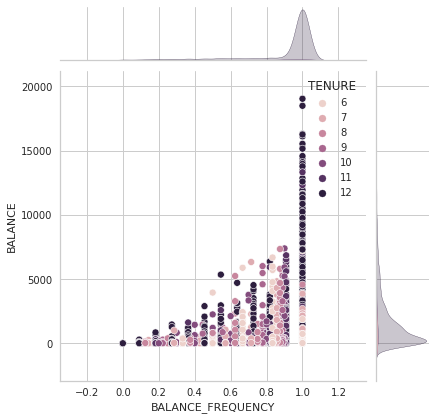

In [28]:
sns.jointplot(data.BALANCE_FREQUENCY, data.BALANCE, hue=data.TENURE);

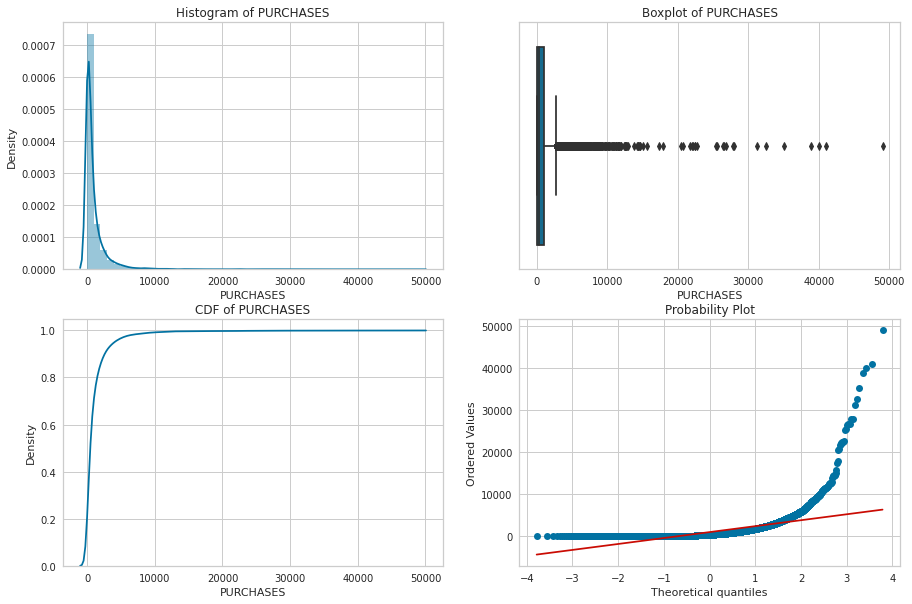

In [29]:
univariate_n(data.PURCHASES)

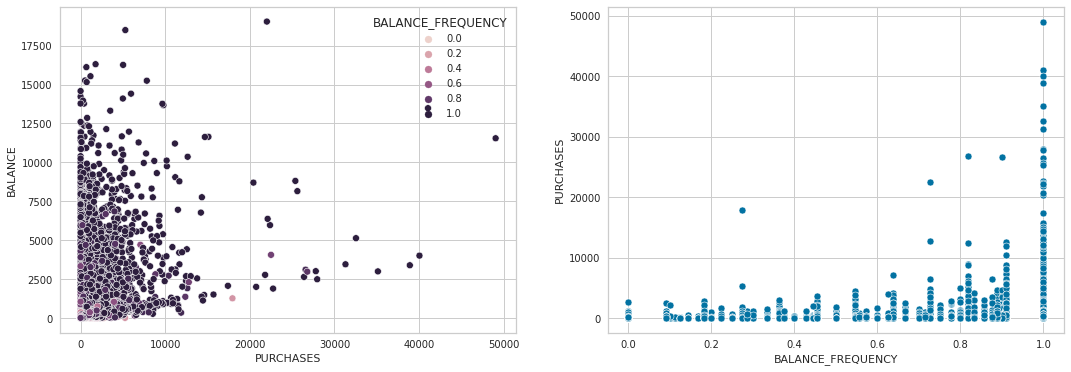

In [30]:
f, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.scatterplot(data.PURCHASES, data.BALANCE, hue=data.BALANCE_FREQUENCY, ax=ax1)
sns.scatterplot(data.BALANCE_FREQUENCY, data.PURCHASES, ax=ax2);

<b>Observations:</b>
- There is no significant relationship between the balance amount and the number of purchases.
- Around 90% have less than 5000 purchases irrespective of the balance and the freequency of balance update.
- Only 20% of the population have a balance freequency of 0.8 or less.
- Close to 80% have a balance less than or equal to 5000. 
- But those who have more than 10000 purchases are mostly users for who the balance update happens freequently. This is obvious but this also linearly grows with the balance itself.

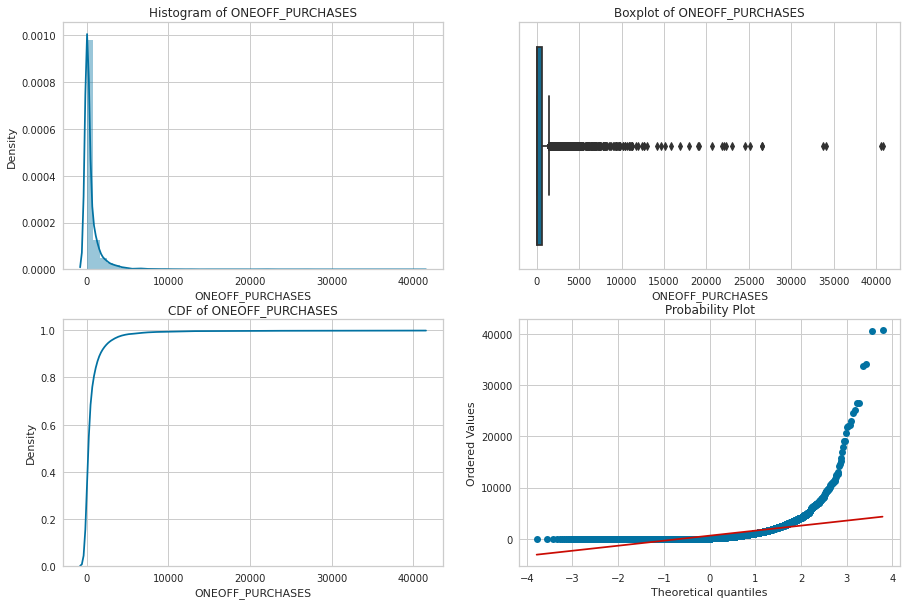

In [31]:
univariate_n(data.ONEOFF_PURCHASES)

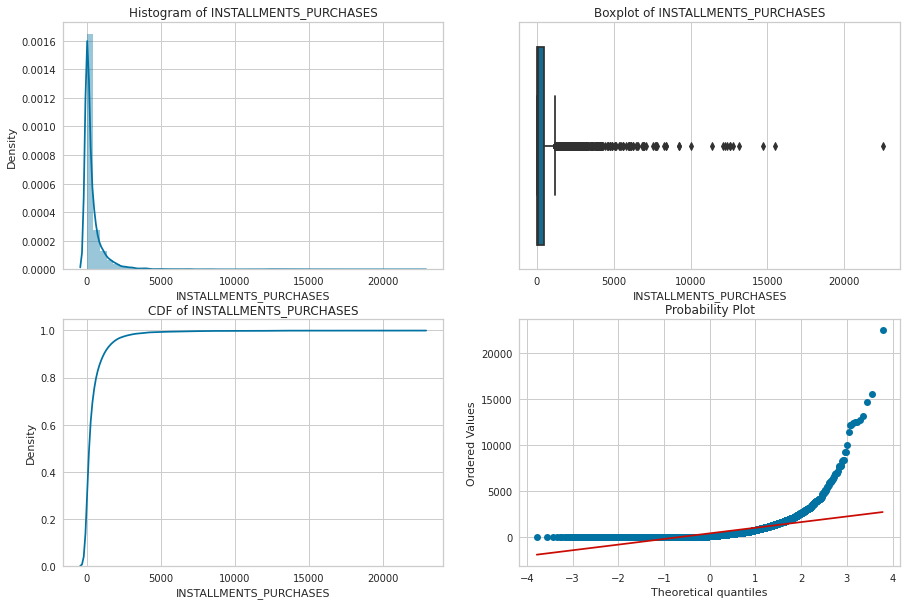

In [32]:
univariate_n(data.INSTALLMENTS_PURCHASES)

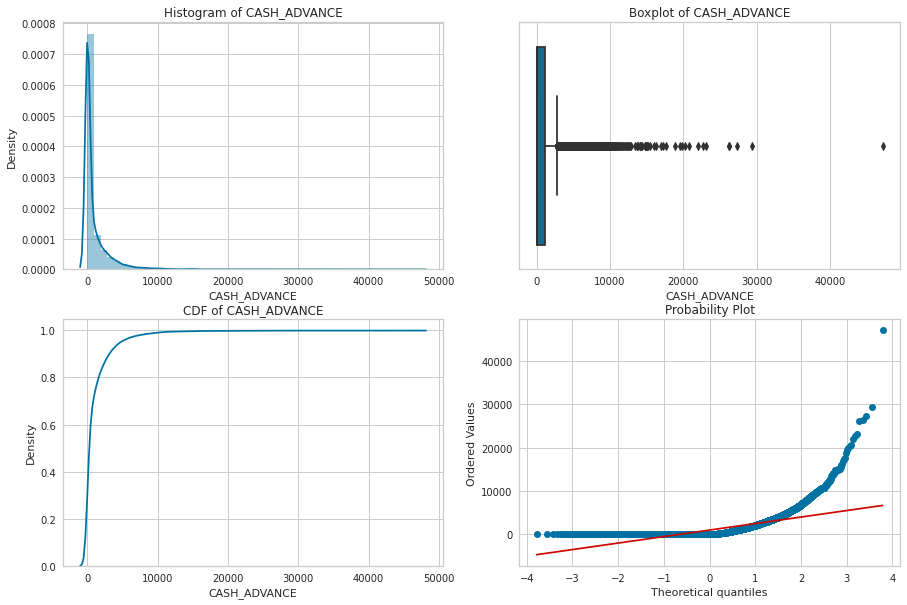

In [33]:
univariate_n(data.CASH_ADVANCE)

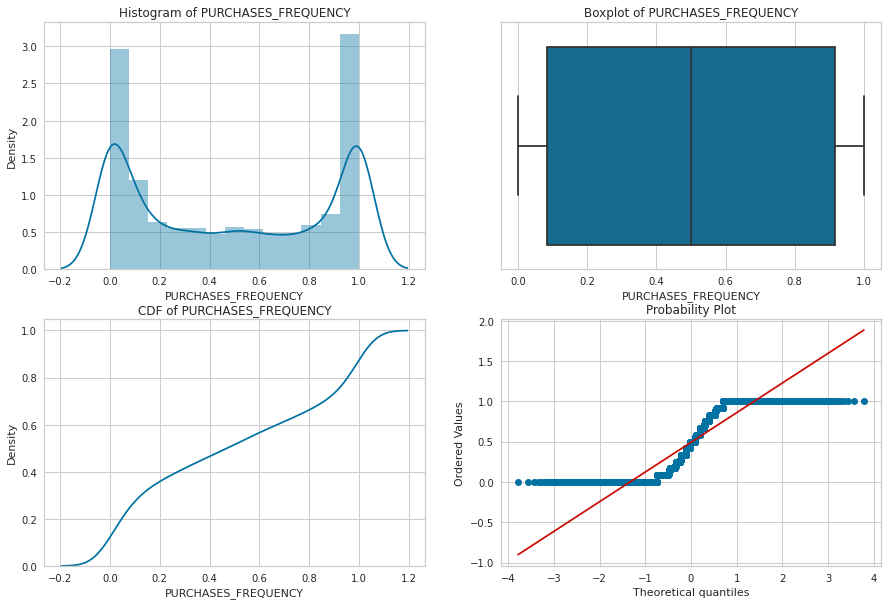

In [34]:
univariate_n(data.PURCHASES_FREQUENCY)

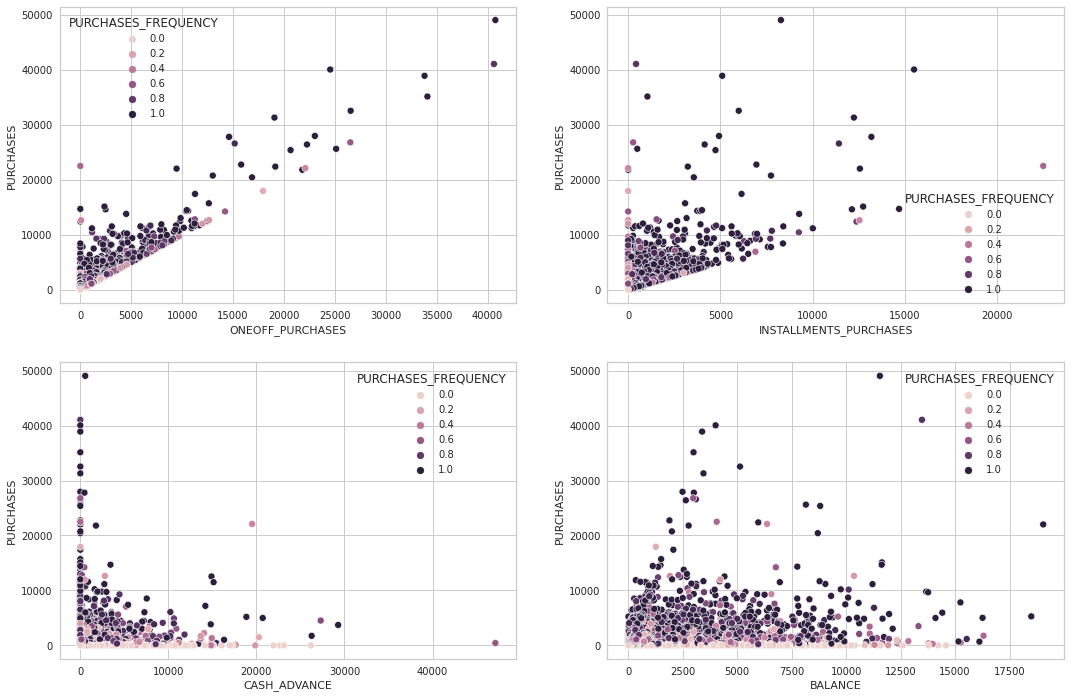

In [35]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
sns.scatterplot(data.ONEOFF_PURCHASES, data.PURCHASES, hue=data.PURCHASES_FREQUENCY, ax=ax[0,0])
sns.scatterplot(data.INSTALLMENTS_PURCHASES, data.PURCHASES, hue=data.PURCHASES_FREQUENCY, ax=ax[0,1])
sns.scatterplot(data.CASH_ADVANCE, data.PURCHASES, hue=data.PURCHASES_FREQUENCY, ax=ax[1,0])
sns.scatterplot(data.BALANCE, data.PURCHASES, hue=data.PURCHASES_FREQUENCY, ax=ax[1,1]);

- A very few people have high oneoff purchases, installment purchases and cash advances.
- Those who have high freequency of purchases made the most purchases regardless of the balance. In fact, people with higher balances rarely seem to make high purchases.
- Those who have the high purchases also have the high one off purchases.
- Most of the installment purchases were made by people with an overall low total but a high freequency of purchases. Most of the peope with low purchase freequency never made any installment purchases.
- People who made high purchases and high freequency of purchases made high installment purchases as well.

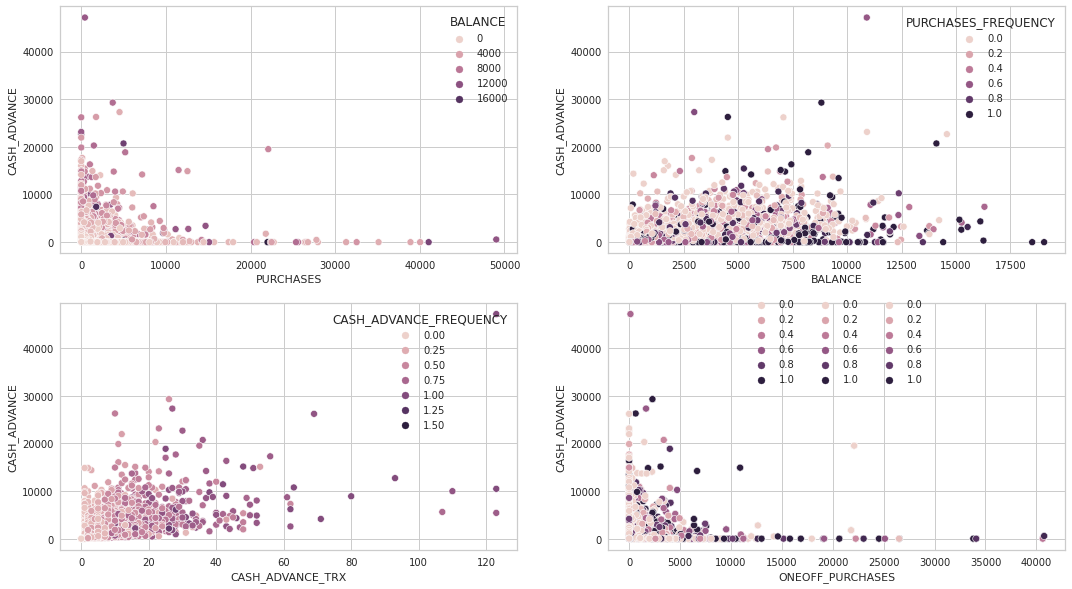

In [36]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
sns.scatterplot(data.PURCHASES, data.CASH_ADVANCE, hue=data.BALANCE, ax=ax[0,0])
sns.scatterplot(data.BALANCE, data.CASH_ADVANCE, hue=data.PURCHASES_FREQUENCY, ax=ax[0,1]);
sns.scatterplot(data.CASH_ADVANCE_TRX, data.CASH_ADVANCE, hue=data.CASH_ADVANCE_FREQUENCY, ax=ax[1,0]);
sns.scatterplot(data.ONEOFF_PURCHASES, data.CASH_ADVANCE, hue=data.PURCHASES_FREQUENCY, ax=ax[1,1]);
sns.scatterplot(data.ONEOFF_PURCHASES, data.CASH_ADVANCE, hue=data.PURCHASES_INSTALLMENTS_FREQUENCY, ax=ax[1,1]);
sns.scatterplot(data.ONEOFF_PURCHASES, data.CASH_ADVANCE, hue=data.PURCHASES_INSTALLMENTS_FREQUENCY, ax=ax[1,1]);
ax[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True);

- Most of the cash advances are from people who have made less overall purchases.
- Those with high case advance are people with low-medium balances.
- Rarely people with high purchase freequency have made high cash advances. The ones who make are people with med-high balances. In addition, those with low cash advance freequencies pay lower cash advances and have low cash advance transactions. Therefore people with high cash transactions are people who pay more and who have an high cash advance freequency.
- Those with high oneoff purchases have low cash advances and these are people with high installment freequencies. Therefore, those with high cash advances are ones with low one off purchases and low installments.

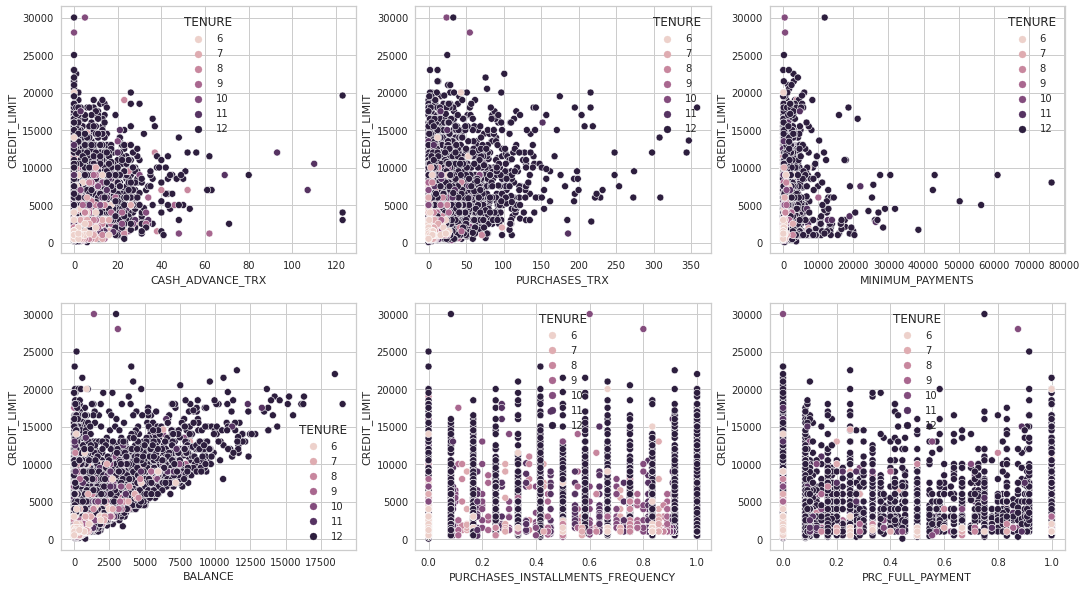

In [37]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
sns.scatterplot(x=data.CASH_ADVANCE_TRX, y=data.CREDIT_LIMIT, hue=data['TENURE'], ax=ax[0,0])
sns.scatterplot(x=data.PURCHASES_TRX, y=data.CREDIT_LIMIT, hue=data['TENURE'], ax=ax[0,1])
sns.scatterplot(x=data.MINIMUM_PAYMENTS, y=data.CREDIT_LIMIT, hue=data['TENURE'], ax=ax[0,2])
sns.scatterplot(x=data.PRC_FULL_PAYMENT, y=data.CREDIT_LIMIT, hue=data['TENURE'], ax=ax[1,2])
sns.scatterplot(x=data.BALANCE, y=data.CREDIT_LIMIT, hue=data['TENURE'], ax=ax[1,0])
sns.scatterplot(x=data.PURCHASES_INSTALLMENTS_FREQUENCY, y=data.CREDIT_LIMIT, hue=data['TENURE'], ax=ax[1,1]);

- Customers who have a higer tenure, also generally tend to have higher balances abd credit limit. Their installment purchase freequency remains the same as customers with a lower tenure and lower purchase.
- In fact, these customer also have a higher purchase transactions compared to others.
- They also generally have a higher percentage of full payments made, and the minimum payments made by them is also generally high.

**Checking the distribution of features before scaling**

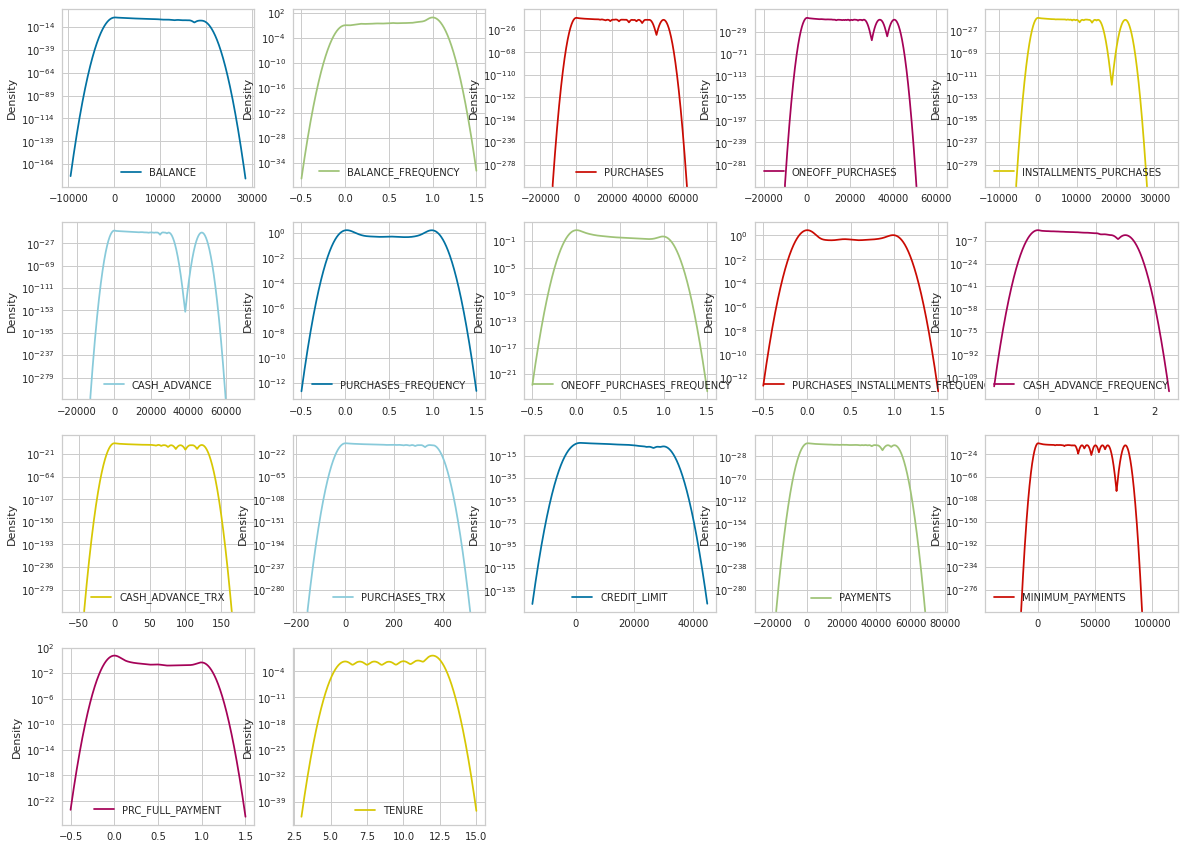

In [38]:
data.plot(subplots=True, kind='kde', layout=(4,5), figsize=(20,15), sharey=False, sharex=False, logy=True);

**Scaling the data using StandardScaler**

In [57]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
scaled_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960433,-0.528979,-0.305482,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688639,0.818642,0.087735,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826062,-0.383805,-0.099870,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826062,-0.598688,NaN,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905464,-0.364368,-0.261102,-0.525551,0.36068


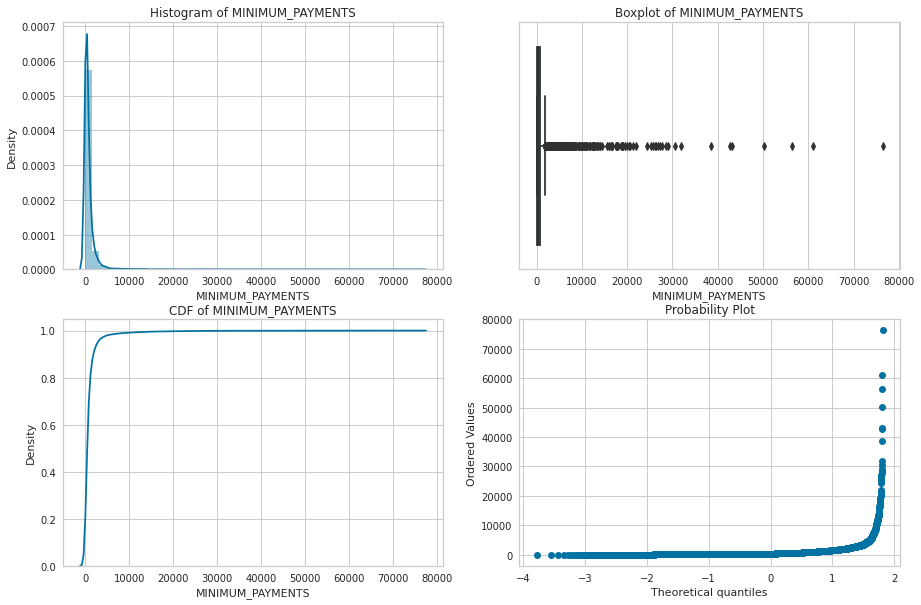

In [40]:
univariate_n(data.MINIMUM_PAYMENTS)

#### Imputing Missing data using KMeans Imputer

In [58]:
imputer = KNNImputer()
scaled_data = imputer.fit_transform(scaled_data)

In [59]:
pd.DataFrame(scaled_data).isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
dtype: int64

# Kmeans

In [180]:
mean_distortions= []
inertias = []
clusters = range(2,10)
silhouttes_orig = {}

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(scaled_data)
    prediction = model.predict(scaled_data)
    mean_distortions.append(sum(np.min(cdist(scaled_data, model.cluster_centers_, 'euclidean'), axis=1))/scaled_data.shape[0])
    inertias.append(model.inertia_)
    silhouttes_orig[k] = silhouette_score(scaled_data, model.labels_)

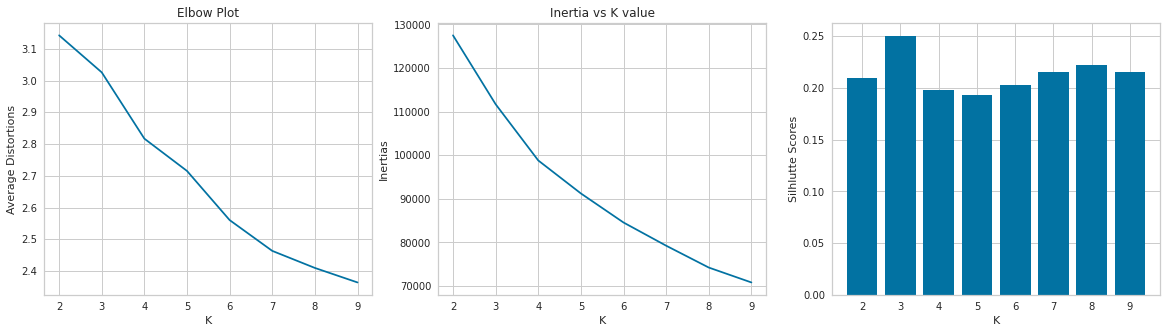

In [191]:
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.lineplot(clusters, mean_distortions, ax=ax1);
ax1.set_xlabel('K')
ax1.set_ylabel('Average Distortions')
ax1.set_title('Elbow Plot')

sns.lineplot(clusters, inertias, ax=ax2);
ax2.set_xlabel('K')
ax2.set_ylabel('Inertias')
ax2.set_title('Inertia vs K value')

ax3.bar(silhouttes_orig.keys(), silhouttes_orig.values())
ax3.set_xlabel('K')
ax3.set_ylabel('Silhlutte Scores');


**There are 3 to 8 clusters**

# Extracting latent features with Autoencoder

### Creating PyTorch Dataloaders

In [61]:
scaled_df = pd.DataFrame(scaled_data)
num_rows = int(scaled_df.shape[0])
X_train = torch.FloatTensor(scaled_df.iloc[:int(scaled_df.shape[0] * 0.80), :].to_numpy())
X_val = torch.FloatTensor(scaled_df.iloc[int(scaled_df.shape[0] * 0.80):, :].to_numpy())

class CustomerDataset(Dataset):
    def __init__(self, X):
        self.X = X;
        self.len = self.X.shape[0]
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        return self.X[idx]
    
train_loader = DataLoader(dataset=X_train, batch_size=64, drop_last=True)
val_loader = DataLoader(dataset=X_val, batch_size=64, drop_last=True)

# for predicting the encoded latent space
data_batches = DataLoader(scaled_data, batch_size=64)

In [68]:
# sanity check
print(type(train_loader.dataset[0]))
print(train_loader.dataset[0].shape)
print(iter(train_loader).next().shape)

<class 'torch.Tensor'>
torch.Size([17])
torch.Size([64, 17])


### Constructing a NN with PyTorch 

In [69]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(17, 85),
            nn.ReLU(),
            nn.Linear(85, 68),
            nn.ReLU(),
            nn.Linear(68, 51),
            nn.ReLU(),
            nn.Linear(51, 34),
            nn.ReLU(),
            nn.Linear(34, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 34),
            nn.ReLU(),
            nn.Linear(34, 51),
            nn.ReLU(),
            nn.Linear(51, 68),
            nn.ReLU(),
            nn.Linear(68, 85),
            nn.ReLU(),
            nn.Linear(85, 17)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [70]:
model = Autoencoder()

In [71]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

### Training Loop

In [72]:
def train(model, data_loader, criterion, optimizer):
    epoch_loss = 0 
    model.train()
    for row in data_loader:
        optimizer.zero_grad()
        pred = model(row.float())
        loss = criterion(pred, row)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    TRAINING_LOSSES.append(epoch_loss/len(data_loader))
    return (epoch_loss/len(data_loader))


def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    model.eval()
    for row in data_loader:
        pred = model(row.float())
        loss = criterion(pred, row)
        epoch_loss += loss.item()
    VALIDATION_LOSS.append(epoch_loss/len(data_loader))
    return (epoch_loss/len(data_loader))

In [73]:
TRAINING_LOSSES = []
VALIDATION_LOSS = []

epochs = 100
for epoch in range(1, epochs+1):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)
    if epoch%5==0:
        print(f"Epoch --> {epoch} || Training Loss --> {train_loss} || Validation Loss --> {val_loss}")

Epoch --> 5 || Training Loss --> 0.4046190821372711 || Validation Loss --> 0.2894944029825705
Epoch --> 10 || Training Loss --> 0.357691684150481 || Validation Loss --> 0.25378044887825296
Epoch --> 15 || Training Loss --> 0.32226265591007097 || Validation Loss --> 0.22905107725549628
Epoch --> 20 || Training Loss --> 0.27550034990181793 || Validation Loss --> 0.19815277556578317
Epoch --> 25 || Training Loss --> 0.26060653471194944 || Validation Loss --> 0.18738012898851325
Epoch --> 30 || Training Loss --> 0.24114785021221316 || Validation Loss --> 0.18020692108957856
Epoch --> 35 || Training Loss --> 0.21699602250848804 || Validation Loss --> 0.16619290135524892
Epoch --> 40 || Training Loss --> 0.1959641396596625 || Validation Loss --> 0.1524555015343207
Epoch --> 45 || Training Loss --> 0.18106059824024234 || Validation Loss --> 0.1363056034401611
Epoch --> 50 || Training Loss --> 0.17019822146441485 || Validation Loss --> 0.12964269629231207
Epoch --> 55 || Training Loss --> 0.17

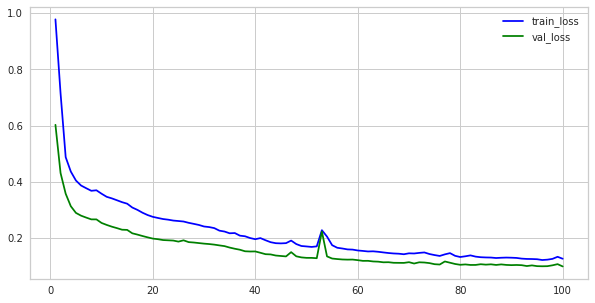

In [74]:
f, ax = plt.subplots(figsize=(10,5))
sns.lineplot(range(1, epochs+1), TRAINING_LOSSES, color='blue', ax=ax, label="train_loss")
sns.lineplot(range(1, epochs+1), VALIDATION_LOSS, color='green', ax=ax, label="val_loss");

### Rereiving the Latent Space from the Encoder

In [75]:
encoded_features = []
with torch.no_grad():
    for row in data_batches:
        pred = model.encoder(row.float()).squeeze(0)
        encoded_features.append(pred)
    print("Done!")

Done!


In [76]:
embeddings = torch.cat(encoded_features, dim=0)
embeddings.shape

torch.Size([8950, 4])

In [77]:
embeddings_df = pd.DataFrame(embeddings.numpy())
embeddings_df.head()

,0,1,2,3
0,-1.076102,1.509771,0.439677,-0.795343
1,-6.229650,5.338240,2.222695,-2.977492
2,-3.068538,-0.075396,-0.647432,0.825233
3,-0.734146,1.601392,0.367998,-1.023681
4,-1.302103,1.479397,0.542242,-0.746957


--------

# Hirarchial Clustering On the Encoded Data

In [203]:
def draw_dendogram(df, method, dist):
    z = linkage(df, method=method)
    cc, cophnetic_distances = cophenet(z, pdist(df, dist))
    print(f"cophenetic correlation coefficient: {cc};\nMethod: {method};\nDistance: {dist}\n")
    dendrogram(z, p=5, truncate_mode='level');

cophenetic correlation coefficient: 0.5870743233314727;
Method: complete;
Distance: euclidean



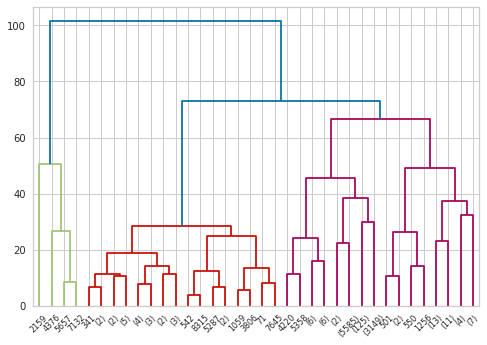

In [204]:
draw_dendogram(embeddings_df, "complete", "euclidean")

cophenetic correlation coefficient: 0.912669361346745;
Method: average;
Distance: minkowski



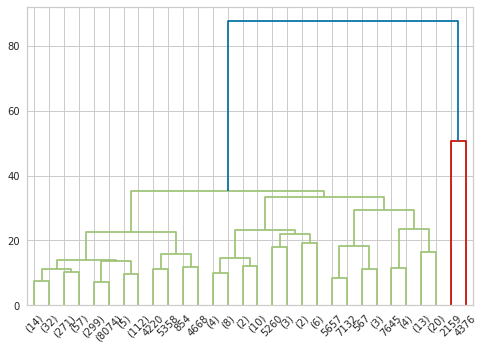

In [205]:
draw_dendogram(embeddings_df, method="average", dist="minkowski")

cophenetic correlation coefficient: 0.912669361346745;
Method: average;
Distance: euclidean



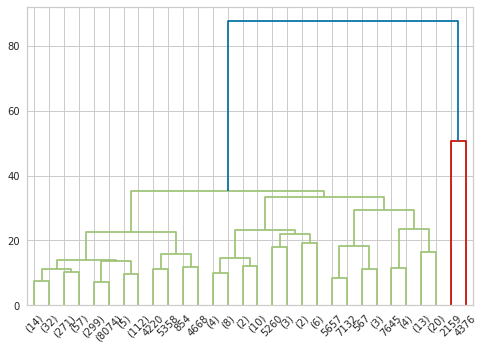

In [206]:
draw_dendogram(embeddings_df, method="average", dist="euclidean")

cophenetic correlation coefficient: 0.8460668774546585;
Method: single;
Distance: euclidean



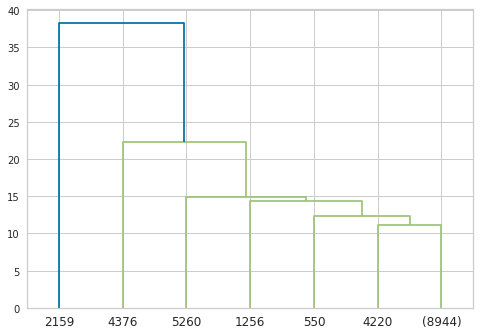

In [207]:
draw_dendogram(embeddings_df, method="single", dist="euclidean")

**There seems to be 3-4 major clusters. Building a model with 3 clusters to check varibility in means of features**

In [100]:
clustering_model = AgglomerativeClustering(n_clusters=3, affinity='manhattan', linkage='average')
clustering_model.fit(embeddings_df)

AgglomerativeClustering(affinity='manhattan', linkage='average', n_clusters=3)

In [101]:
n_clusters = clustering_model.fit_predict(embeddings_df)

In [102]:
embeddings_df['n_clusters'] = n_clusters

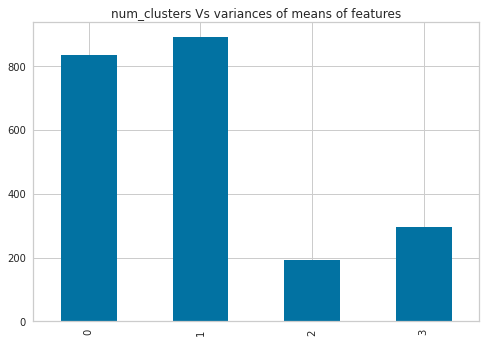

In [209]:
embeddings_df.groupby("n_clusters").mean().var().plot(kind="bar", title="num_clusters Vs variances of means of features");

**Observation:** The variance in the means of first 2 latent features seem to be high. But, this is not the case for next 2 features.

In [211]:
mean_distortions_enc = []
inertias_enc = []
silhouttes_enc = {}
clusters = range(2,10)
variance_df = pd.DataFrame(index=scaled_df.columns)
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(embeddings_df)
    prediction = model.predict(embeddings_df)
    mean_distortions_enc.append(sum(np.min(cdist(embeddings_df, model.cluster_centers_, 'euclidean'), axis=1))/embeddings_df.shape[0])
    inertias_enc.append(model.inertia_)
    
    silhouttes_enc[k] = silhouette_score(embeddings_df, model.labels_)
    
    temp = pd.DataFrame(scaled_data, columns=data.columns)
    temp["pred"] = prediction
    variance_df[str(k)] = temp.groupby("pred").mean().std()

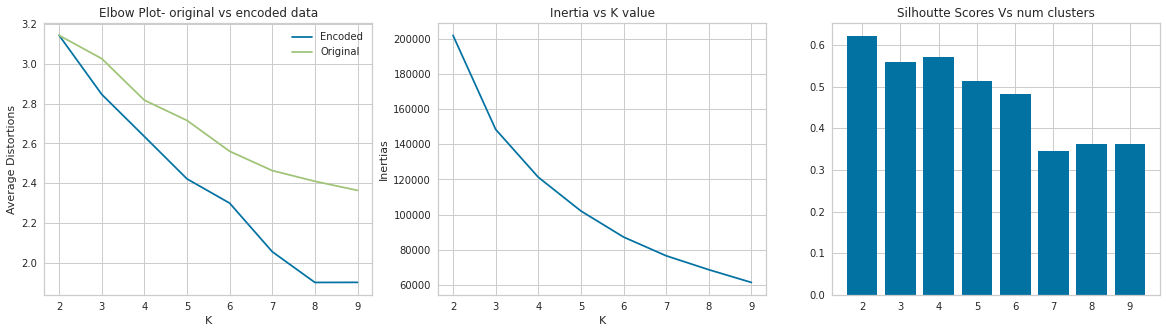

In [214]:
f, ax = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
sns.lineplot(clusters, mean_distortions_enc, ax=ax[0], label="Encoded");
sns.lineplot(clusters, mean_distortions, ax=ax[0], label="Original");
ax[0].set_xlabel('K')
ax[0].set_ylabel('Average Distortions')
ax[0].set_title('Elbow Plot- original vs encoded data')
ax[0].legend()

sns.lineplot(clusters, inertias_enc, ax=ax[1]);
ax[1].set_xlabel('K')
ax[1].set_ylabel('Inertias')
ax[1].set_title('Inertia vs K value');

ax[2].bar(silhouttes_enc.keys(), silhouttes_enc.values())
ax[2].set_title('Silhoutte Scores Vs num clusters');

### Visualizing the variances in means of features for different clusters

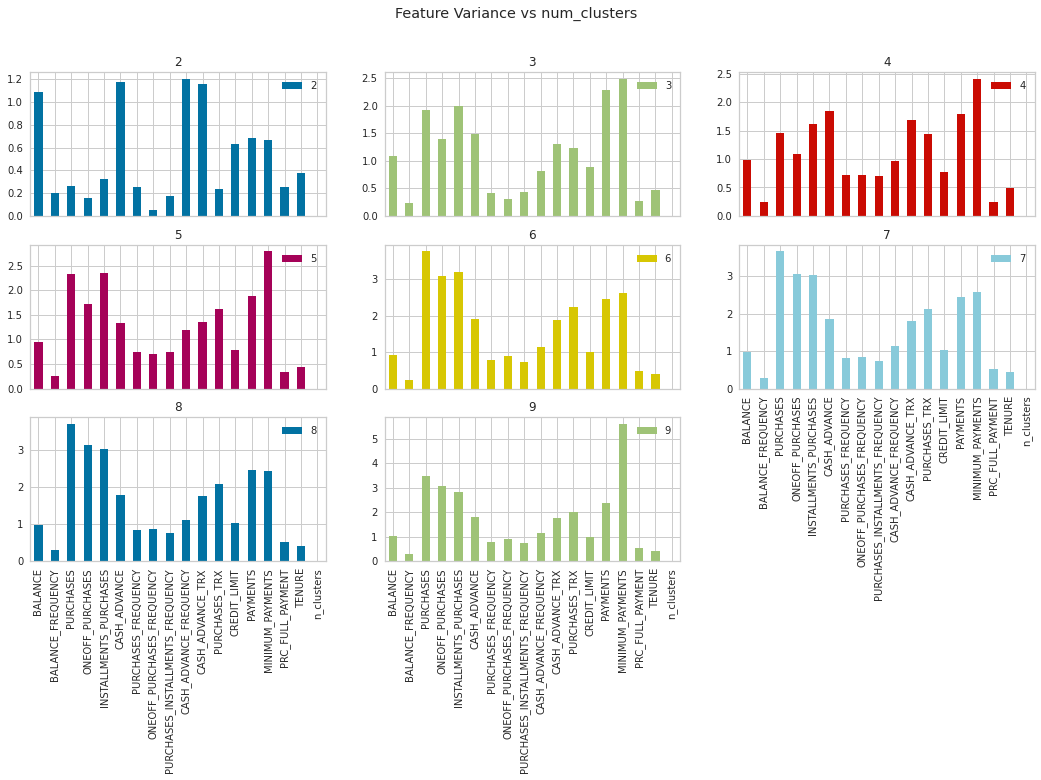

In [174]:
variance_df.iloc[:, 1:].plot(kind='bar', subplots=True, figsize=(18, 9), layout=(3,3), title="Feature Variance vs num_clusters");

**Observation: & Inference:**

- There are 2 major clusters in the data as indicated by the silhoute scores of the kmeans model on encoded data.
- The 2nd cluster further subdivides into 3 sub clusters. These clusters are not very far away from each other. Hence we are not able to see much improvement in variance of means of features, as well as in silhoutte scores for k > 3.
- Hence, it would not be unreasonable to choose the value of k to be 3.

## Building a kmeans model with k=3 on encoded data

In [219]:
final_model = KMeans(n_clusters=3)
final_model.fit(embeddings_df)
y_pred = final_model.predict(embeddings_df)

scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
scaled_df['n_clusters'] = y_pred

In [220]:
groups = scaled_df.groupby('n_clusters')
groups.mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
n_clusters,,,,,,,,,,,,,,,,,
0,-0.268491,-0.042166,-0.031815,-0.015014,-0.047638,-0.286364,0.110254,0.037238,0.083769,-0.321081,-0.282825,-0.019191,-0.142288,-0.144072,-0.153500,0.088336,0.147407
1,0.989036,0.148185,-0.062469,-0.077705,-0.004840,1.019839,-0.471976,-0.176558,-0.372983,1.265801,1.025270,-0.042369,0.489306,0.357438,0.328750,-0.368251,-0.617308
2,1.850661,0.412362,3.282449,2.371201,3.402673,2.571168,0.362474,0.414816,0.520649,0.797399,2.231971,2.059921,1.574746,3.947264,4.355657,0.121640,0.250791


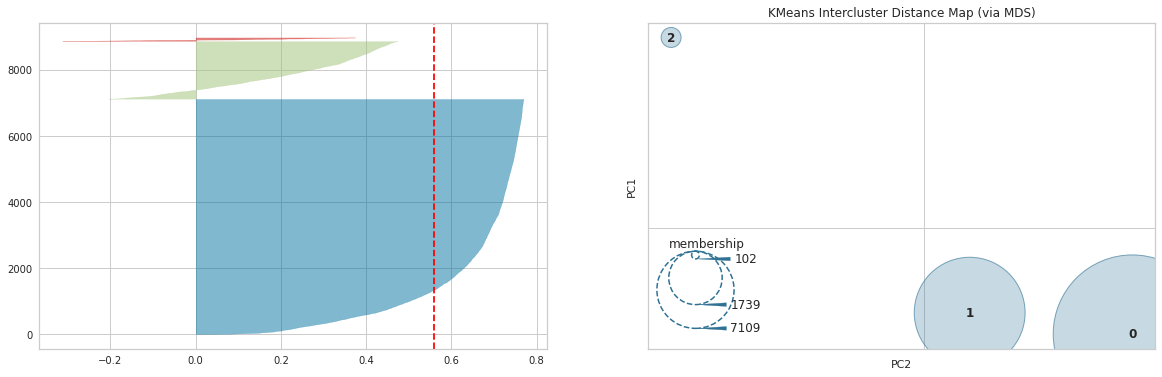

In [223]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
visualizer1 = SilhouetteVisualizer(final_model, colors='yellowbrick', ax=ax1)
visualizer1.fit(embeddings_df)
visualizer2 = InterclusterDistance(final_model, ax=ax2)
visualizer2.fit(embeddings_df)
visualizer2.show();

# Analyzing the clusters on the original data

In [259]:
varying_features = list(variance_df[variance_df.apply(lambda x: x>1, axis=0)].loc[:, "3"].dropna().index)
varying_features.append("n_clusters")

In [256]:
data["n_clusters"] = y_pred

In [263]:
data.loc[:, varying_features].dropna().groupby("n_clusters").median()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS
n_clusters,,,,,,,,,
0,579.875088,438.815,61.695,144.785,0.000000,0.0,9.0,769.595380,235.494685
1,3006.594256,71.070,0.000,0.000,2685.118122,9.0,1.0,1647.245926,1047.765097
2,4295.389893,1787.110,116.815,994.945,452.120079,1.5,21.0,12102.338045,2603.428233


**Inference:**

- The 3 clusters of customers are distinct.
- The first group are customers who maintain low balance and spend less. They often do not make many transactions, and in the case that they do, they do not spend a lot.
- The second group of customers maintain a reasonably high balance. But they do not make many transactions with their card. Instead, they opt to take cash advances and probably only use cash for transactions. This group does not use their credit card for any transaction.
- The third lot is a minority who both maintain high balance, and also make many high value purchases with their card, and spend a lot in general. They do not take much cash advances probably because their spend from debit and only use credit card for their purchases. 

<hr>